In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import yaml

from gammapy.datasets import MapDataset, Datasets, FluxPointsDataset
from gammapy.maps import Map
from gammapy.makers import FoVBackgroundMaker
from gammapy.catalog import SourceCatalogHGPS
from gammapy.modeling.models import SkyModel, TemplateSpatialModel, PowerLawNormSpectralModel, Models

In [2]:
def open_dataset(name, hessera):
    dataset= MapDataset.read(f'{mainpath_hess}/{name}.fits')
    dataset.mask_safe = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
    dataset.mask_safe &= dataset.counts.geom.region_mask(f"galactic;circle(0, 0, 3)")
    
    dataset.mask_fit = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
    dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(358.71, -0.64, 0.7)")

    if hessera == 'hess1':
        dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(359.5, -0.2, 0.2)")
        dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(358.45, 0.15, 0.35)")

    return dataset

In [3]:
hesseras=['hess1', 'hess2', 'hess1u']
muoneff_flag= True
edisp = True

info_list = [] #hessera, muoneff, edisp, name

mainpath_hess = '/home/vault/caph/mppi062h/repositories/GC/HESS'

for hessera in hesseras:
    if hessera =='hess1u':
        muoneff_flag=False
        
    if hessera == 'hess1':
        name_afterFermi='v1'
        for name_afterFermi_idx in range(3):
            name = f'20220702_{hessera}_muoneff{muoneff_flag}_edisp{edisp}_afterFermi{name_afterFermi}_{name_afterFermi_idx}'
            info_list.append([hessera, muoneff_flag, edisp, name])
    else:
        name = f'20220702_{hessera}_muoneff{muoneff_flag}_edisp{edisp}'
        info_list.append([hessera, muoneff_flag, edisp, name])
    
datasets_hess = []
for i in range(len(info_list)):
    datasets_hess.append(open_dataset(info_list[i][3], info_list[i][0])) 

In [4]:
catalog = SourceCatalogHGPS()

## if you are doing the fit

In [5]:
mask1 = np.abs(catalog.table['GLAT']) < 2.6
mask2 = (catalog.table['GLON'] < 2.6) + (catalog.table['GLON'] > 357.4)
mask = mask1 & mask2
HGPS_models = catalog[mask].to_models()

filename='/home/saturn/caph/mppi043h/diffusiontemplate/cont_pcut_v3.fits'
diff_map = Map.read(filename)
diff= SkyModel(spectral_model=PowerLawNormSpectralModel(),
               spatial_model=TemplateSpatialModel(diff_map, normalize=False, filename=filename),
               name='diff-emission')
diff.parameters['tilt'].frozen=False

initial_model_hess = HGPS_models
initial_model_hess.append(diff)

In [6]:
frozen_sources= ['HESS J1745-303', 'HESS J1746-308', 'HESS J1741-302', 'HESS J1746-285']

for s in initial_model_hess:
    if s.name in frozen_sources:
        s.parameters.freeze_all()
        
frozen_pos_sources= ['HESS J1745-290', 'HESS J1747-281']
for s in initial_model_hess:
    if s.name in frozen_pos_sources:
        s.spatial_model.parameters.freeze_all()


In [7]:
print(initial_model_hess)

Models

Component 0: SkyModel

  Name                      : HESS J1741-302
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index        (frozen)   :      2.300                   
    amplitude    (frozen)   :   2.10e-13       1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lon_0        (frozen)   :    358.277       deg         
    lat_0        (frozen)   :      0.049       deg         

Component 1: SkyModel

  Name                      : HESS J1745-290
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      2.140   +/-    0.02             
    amplitude               :   2.55e-12   +/- 4.0e-14 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000    

In [8]:
from gammapy.modeling import Fit

for idx, hess in enumerate(datasets_hess):
    hess.models = initial_model_hess.copy()
    hess = FoVBackgroundMaker().make_default_fov_background_model(dataset=hess)
    hess.models[-1].parameters['tilt'].frozen=False
    
    result0= Fit().run(datasets=[hess])
    print(result0)
    
    with open(f'fitted_model_{info_list[idx][3]}.yml', 'w') as outfile:
        yaml.dump(hess.models.to_dict(), outfile, default_flow_style=False)

Template file already exits, and overwrite is False


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 650
	total stat : 775080.47

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 650
	total stat : 775080.47




Template file already exits, and overwrite is False


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 839
	total stat : 549719.77

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 839
	total stat : 549719.77




Template file already exits, and overwrite is False


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 646
	total stat : 508339.91

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 646
	total stat : 508339.91




Template file already exits, and overwrite is False


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 742
	total stat : 505479.47

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 742
	total stat : 505479.47




Template file already exits, and overwrite is False


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 963
	total stat : 665777.37

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 963
	total stat : 665777.37




## if you are just checking the results

In [17]:
import os
models_std = []
for idx in range(len(datasets_hess)):
    model_path = f'../fitted_model_{info_list[idx][3]}.yml'
    if os.path.exists(model_path):
        models_std.append(Models.read(model_path))

In [10]:
colors = ['navy', 'C0', 'C1', 'C2', 'C5']
central_source = 'HESS J1745-290'
G09 = 'HESS J1747-281'

x_axis = hess.counts.geom.axes['energy'].center.value
energy_bounds = [0.3, 100] * u.TeV
sed_type = "e2dnde"

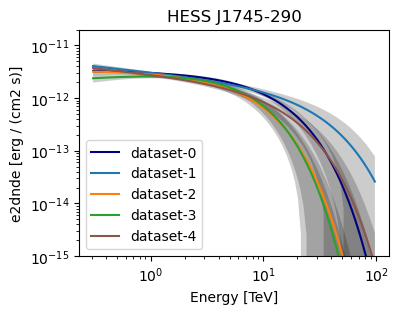

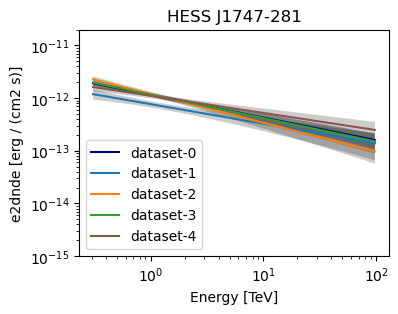

In [11]:
for source in frozen_pos_sources:
    fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)
    for idx, hess in enumerate(datasets_hess):
        hess.models[source].spectral_model.plot(ax=ax, color=colors[idx],
            energy_bounds=energy_bounds, sed_type=sed_type, label=f'dataset-{idx}')
        hess.models[source].spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)
    plt.legend(loc='lower left')
    plt.ylim(1e-15, 2e-11)
    plt.title(source)
    plt.show()

Text(0.5, 1.0, 'HESS J1747-281')

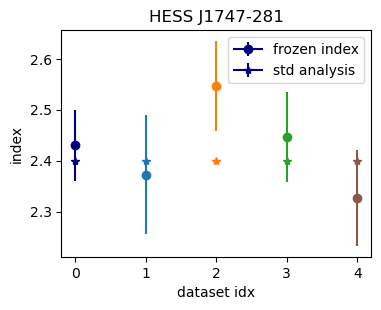

In [12]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

source = G09

for idx, hess in enumerate(datasets_hess):
    label= None
    label_std = None
    if idx ==0:
        label_std='std analysis'
        label='frozen index'
    par='index'
    plt.errorbar(idx, hess.models[source].spectral_model.parameters[par].value, 
                 yerr=hess.models[source].spectral_model.parameters[par].error,
                 color=colors[idx], label=label, marker='o')
    plt.errorbar(idx, models_std[idx][source].spectral_model.parameters[par].value,
                 yerr=models_std[idx][source].spectral_model.parameters[par].error,
                 color=colors[idx], marker='*', label=label_std)
ax.set_xlabel('dataset idx')
ax.set_ylabel('index')
plt.legend()
plt.title(source)

Text(0.5, 1.0, 'HESS J1747-281')

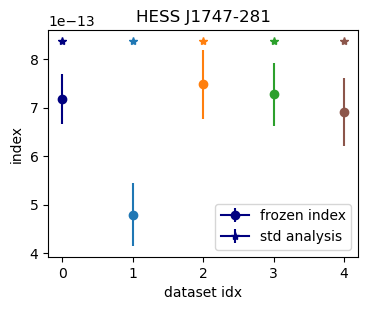

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

source = G09

for idx, hess in enumerate(datasets_hess):
    label= None
    label_std = None
    if idx ==0:
        label_std='std analysis'
        label='frozen index'
    par='amplitude'
    plt.errorbar(idx, hess.models[source].spectral_model.parameters[par].value, 
                 yerr=hess.models[source].spectral_model.parameters[par].error,
                 color=colors[idx], label=label, marker='o')
    plt.errorbar(idx, models_std[idx][source].spectral_model.parameters[par].value,
                 yerr=models_std[idx][source].spectral_model.parameters[par].error,
                 color=colors[idx], marker='*', label=label_std)
ax.set_xlabel('dataset idx')
ax.set_ylabel('index')
plt.legend()
plt.title(source)

Text(0.5, 1.0, 'HESS J1747-281')

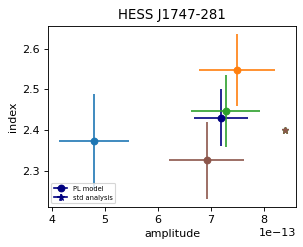

In [14]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=80)

source=G09
for idx, hess in enumerate(datasets_hess):
    label= None
    label_std = None
    if idx ==0:
        label_std='std analysis'
        label='PL model'
        
    parx = 'amplitude'
    pary = 'index'
    
    plt.errorbar(hess.models[source].spectral_model.parameters[parx].value,  
                hess.models[source].spectral_model.parameters[pary].value, 
                xerr=hess.models[source].spectral_model.parameters[parx].error, 
                yerr=hess.models[source].spectral_model.parameters[pary].error, 
                color=colors[idx], label=label, marker='o')
    plt.errorbar(models_std[idx][source].spectral_model.parameters[parx].value,  
                models_std[idx][source].spectral_model.parameters[pary].value, 
                xerr=models_std[idx][source].spectral_model.parameters[parx].error, 
                yerr=models_std[idx][source].spectral_model.parameters[pary].error, 
                color=colors[idx], label=label_std, marker='*')

ax.set_xlabel('amplitude')
ax.set_ylabel('index')
plt.legend(loc='lower left', prop={'size': 6})
plt.title(source)

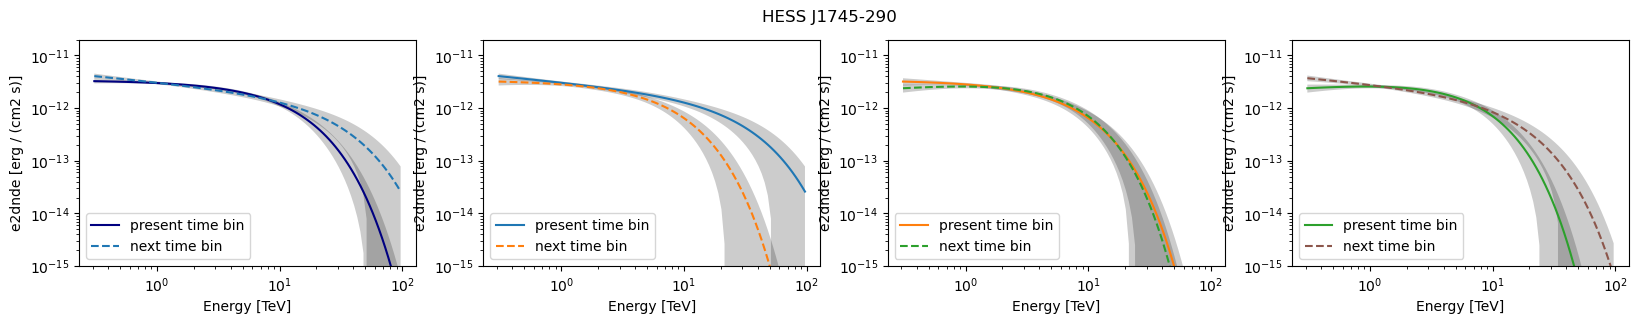

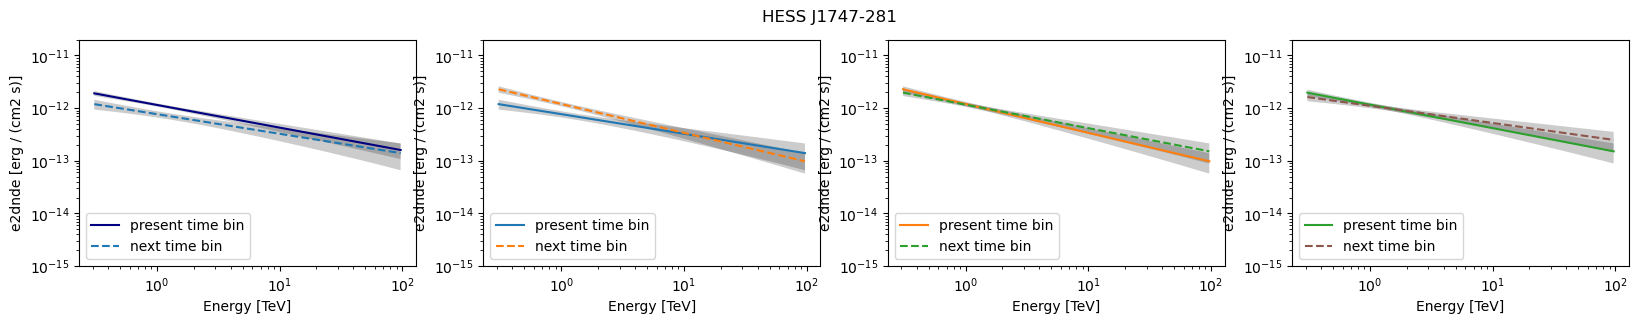

In [15]:
for source in frozen_pos_sources:
    fig, ax = plt.subplots(1,4, figsize=(20, 3), dpi=100)
    for idx in range(len(info_list)-1):    
        datasets_hess[idx].models[source].spectral_model.plot(ax=ax[idx],color=colors[idx],
            energy_bounds=energy_bounds, sed_type=sed_type, label=f'present time bin')
        datasets_hess[idx].models[source].spectral_model.plot_error(ax=ax[idx], energy_bounds=energy_bounds, sed_type=sed_type)

        datasets_hess[idx+1].models[source].spectral_model.plot(ax=ax[idx],color=colors[idx+1],
            energy_bounds=energy_bounds, sed_type=sed_type, label=f'next time bin', ls='--')
        datasets_hess[idx+1].models[source].spectral_model.plot_error(ax=ax[idx], energy_bounds=energy_bounds, sed_type=sed_type)

        ax[idx].set_ylim(1e-15, 2e-11)
        ax[idx].legend(loc='lower left')
    plt.suptitle(source)
    plt.show()

/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/maps/wcs/ndmap.py:372: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


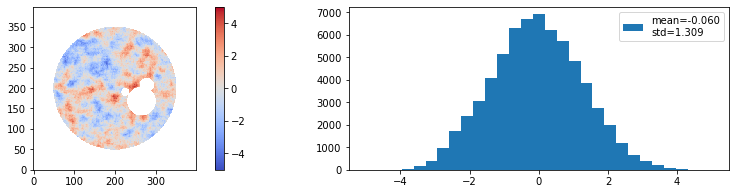

/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/maps/wcs/ndmap.py:372: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


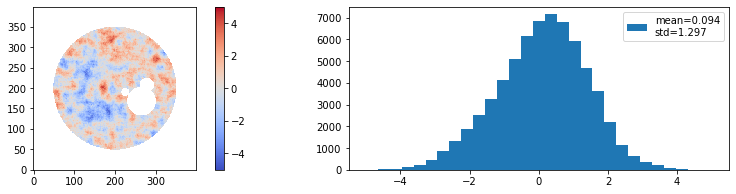

/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/maps/wcs/ndmap.py:372: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


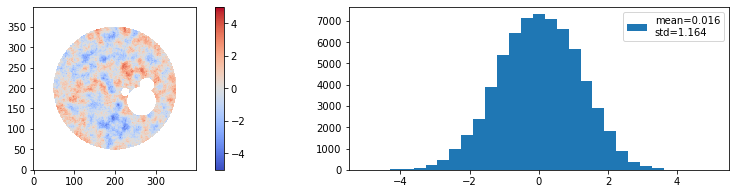

/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/maps/wcs/ndmap.py:372: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


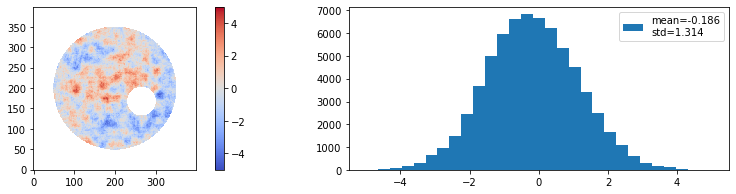

/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/gammapy/maps/wcs/ndmap.py:372: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.imshow(data, **kwargs)


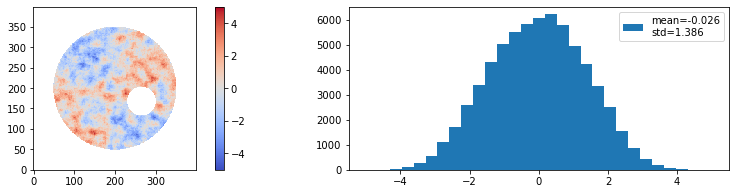

In [16]:
from gammapy.estimators import ExcessMapEstimator

estimator = ExcessMapEstimator(
    correlation_radius="0.2 deg",
    selection_optional=[],
    energy_edges=[0.1, 100] * u.TeV,
)
for idx, hess in enumerate(datasets_hess):
    result = estimator.run(hess)
    fig, ax = plt.subplots(1,2, figsize=(15, 3))
    result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ax=ax[0]);
    data=result["sqrt_ts"].data.ravel()
    ax[1].hist(data, bins=np.linspace(-5,5,30), label=f'mean={np.nanmean(data):.3f}\nstd={np.nanstd(data):.3f}');
    plt.legend()
    plt.show()